In [2]:
###########################
#  Master thesis
# 
# UNIVERSITY: 
#  Faculty of Information Technology, Brno University of Technology
# 
# AUTHOR:
#  Aleš Kašpárek          <xkaspa48@stud.fit.vutbr.cz>
###########################

import math
import json
import torch

import numpy as np
import pandas as pd
import torch.nn as nn

from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [7]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRUModel, self).__init__()
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)

        return out 


def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append([target])
    return torch.tensor(X, dtype=torch.float32).unsqueeze(1), torch.tensor(y, dtype=torch.float32)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESULTS = {}


def train_fnc(config):
    network_analytics = pd.read_csv('./data/Network_Analytics.csv')
    network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
    network_analytics = network_analytics.set_index('Timestamp')

    X = network_analytics['OutboundUtilzation (%)'].values
    size = int(len(X) * 0.80)
    test_size = int(len(X) * 0.01)
    train_set, test_set = X[0:size], X[size:len(X)]
    train_set, test_set = X[0:size], X[-test_size:len(X)]

    input_size = config['input_size']
    hidden_size = 1
    num_layers = 1
    output_size = 1

    X_train, y_train = create_dataset(train_set, lookback=input_size)
    X_test, y_test = create_dataset(test_set, lookback=input_size)
  
    model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = np.inf

    train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=1024)
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

    for epoch in range(200):
        running_loss = .0
        model.train()

        for idx, (inputs,labels) in enumerate(train_loader):
            # print(inputs.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss

        train_loss = running_loss/len(train_loader)
  
        # Validation loss
        running_loss = .0
        model.eval()
        predicted = []
        actuals = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs.float())
                loss = criterion(preds,labels)
                running_loss += loss
                predicted.extend(preds.detach().cpu().numpy())
                actuals.extend(labels.detach().cpu().numpy())

            valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
        if valid_loss < best_loss:
            # print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
            best_loss = valid_loss


    RESULTS[config['input_size']] = best_loss
    print("Finished Training")

In [ ]:
for x in range(1, 31):
    train_fnc({'input_size' : x})

with open('../outputs/gru_input_size.json', 'w') as json_file:
    json.dump(RESULTS, json_file)

2


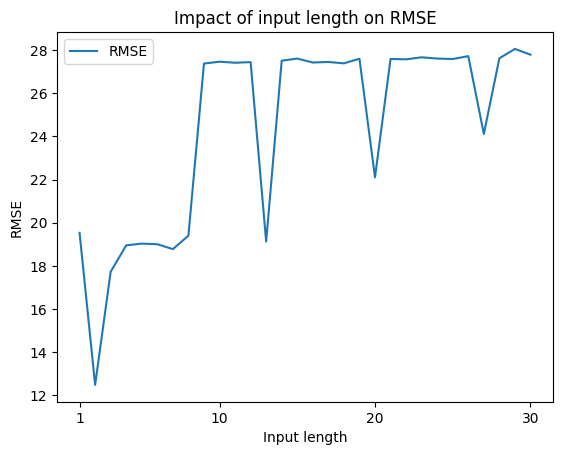

In [3]:
import matplotlib.pyplot as plt

with open('../outputs/gru_input_size.json', 'r') as json_file:
    res = json.load(json_file)
d = {int(k):v for k,v in res.items()}

lists = sorted(d.items())
x, y = zip(*lists)
print(min(d, key=d.get))
plt.xlabel('Input length')
plt.ylabel('RMSE')
plt.title('Impact of input length on RMSE')
plt.xticks([1, 10, 20, 30])
plt.plot(x, y, label='RMSE')
plt.legend(loc='best')
plt.show()

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESULTS = {}


def train_fnc(config):
    network_analytics = pd.read_csv('./data/Network_Analytics.csv')
    network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
    network_analytics = network_analytics.set_index('Timestamp')

    X = network_analytics['OutboundUtilzation (%)'].values
    size = int(len(X) * 0.80)
    test_size = int(len(X) * 0.01)
    train_set, test_set = X[0:size], X[size:len(X)]
    train_set, test_set = X[0:size], X[-test_size:len(X)]

    input_size = 2
    hidden_size = config['hidden_size']
    num_layers = 3
    output_size = 1

    X_train, y_train = create_dataset(train_set, lookback=input_size)
    X_test, y_test = create_dataset(test_set, lookback=input_size)
  
    model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = np.inf

    train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=1024)
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

    for epoch in range(200):
        running_loss = .0
        model.train()

        for idx, (inputs,labels) in enumerate(train_loader):
            # print(inputs.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss

        train_loss = running_loss/len(train_loader)
  
        # Validation loss
        running_loss = .0
        model.eval()
        predicted = []
        actuals = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs.float())
                loss = criterion(preds,labels)
                running_loss += loss
                predicted.extend(preds.detach().cpu().numpy())
                actuals.extend(labels.detach().cpu().numpy())

            valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
        if valid_loss < best_loss:
            # print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
            best_loss = valid_loss


    RESULTS[config['hidden_size']] = best_loss
    print("Finished Training")

In [ ]:
for x in range(1, 61):
    train_fnc({'hidden_size' : x})

with open('../outputs/gru_hidden_size.json', 'w') as json_file:
    json.dump(RESULTS, json_file)

59


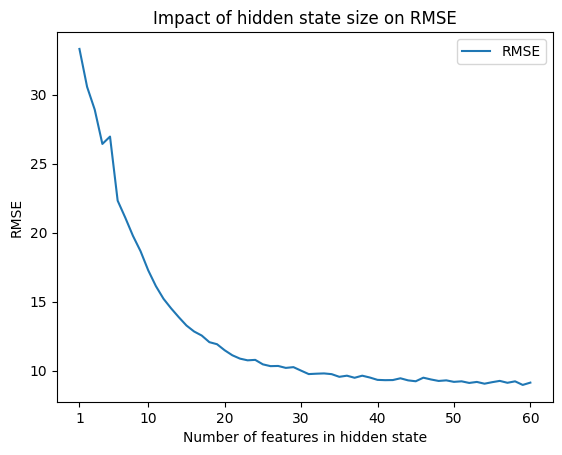

In [5]:
import json
import matplotlib.pyplot as plt

with open('../outputs/gru_hidden_size.json', 'r') as json_file:
    res = json.load(json_file)
d = {int(k):v for k,v in res.items()}

lists = sorted(d.items())
x, y = zip(*lists)
print(min(d, key=d.get))
plt.xlabel('Number of features in hidden state')
plt.title('Impact of hidden state size on RMSE')
plt.ylabel('RMSE')
plt.xticks([1, 10, 20, 30, 40, 50, 60])
plt.plot(x, y, label='RMSE')
plt.legend(loc='best')
plt.show()

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESULTS = {}


def train_fnc(config):
    network_analytics = pd.read_csv('./data/Network_Analytics.csv')
    network_analytics['Timestamp'] = pd.to_datetime(network_analytics['Timestamp'])
    network_analytics = network_analytics.set_index('Timestamp')

    X = network_analytics['OutboundUtilzation (%)'].values
    size = int(len(X) * 0.80)
    test_size = int(len(X) * 0.01)
    train_set, test_set = X[0:size], X[size:len(X)]
    train_set, test_set = X[0:size], X[-test_size:len(X)]

    input_size = 2
    hidden_size = 50
    num_layers = config['hidden_units']
    output_size = 1

    X_train, y_train = create_dataset(train_set, lookback=input_size)
    X_test, y_test = create_dataset(test_set, lookback=input_size)
  
    model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = np.inf

    train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=1024)
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

    for epoch in range(200):
        running_loss = .0
        model.train()

        for idx, (inputs,labels) in enumerate(train_loader):
            # print(inputs.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss

        train_loss = running_loss/len(train_loader)
  
        # Validation loss
        running_loss = .0
        model.eval()
        predicted = []
        actuals = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                preds = model(inputs.float())
                loss = criterion(preds,labels)
                running_loss += loss
                predicted.extend(preds.detach().cpu().numpy())
                actuals.extend(labels.detach().cpu().numpy())

            valid_loss = math.sqrt(mean_squared_error(actuals, predicted))
        if valid_loss < best_loss:
            # print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, valid_loss))
            best_loss = valid_loss


    RESULTS[config['hidden_units']] = best_loss
    print("Finished Training")

In [ ]:
for x in range(1, 31):
    train_fnc({'hidden_units' : x})

with open('../outputs/gru_hidden_units.json', 'w') as json_file:
    json.dump(RESULTS, json_file)

3


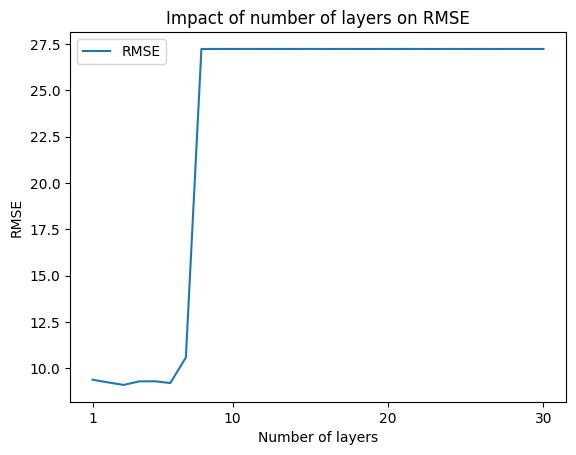

In [6]:
import matplotlib.pyplot as plt

with open('../outputs/gru_hidden_units.json', 'r') as json_file:
    res = json.load(json_file)
d = {int(k):v for k,v in res.items()}

lists = sorted(d.items())
x, y = zip(*lists)
print(min(d, key=d.get))
plt.ylabel('RMSE')
plt.xlabel('Number of layers')
plt.title('Impact of number of layers on RMSE')
plt.xticks([1, 10, 20, 30, 40, 50])
plt.plot(x, y, label='RMSE')
plt.legend(loc='best')
plt.show()